In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pycuda.gpuarray as gpuarray
from pycuda.autoinit import context
import pycuda.driver as cuda
import pycuda.autoinit

dev=cuda.Device(3)
dev.make_context()
from scipy.ndimage import gaussian_filter

GT=np.load('AuxData/Ti7FFT.npy')
# row content
# 0  dilation
# 1  E11
# 2  E12
# 3  E13
# 4  E22
# 5  E23
# 6  E33
# 7  Grain ID
# 8  Phi1
# 9  Psi
# 10 Phi2
orig=[-0.256,-0.256]
step=[0.002,0.002]
gid=40
# gid=23

GIDLayer=GT[7].astype(int)
tmpx=np.arange(orig[0],step[0]*GIDLayer.shape[0]+orig[0],step[0])
tmpy=np.arange(orig[1],step[1]*GIDLayer.shape[1]+orig[1],step[1])
xv,yv=np.meshgrid(tmpx,tmpy)
idx=np.where(GIDLayer==gid)
x=xv[idx]
y=yv[idx]

tmpDil=GT[0][idx]*20
tmpE11=GT[1][idx]*20
tmpE12=GT[2][idx]*20
tmpE13=GT[3][idx]*20
tmpE22=GT[4][idx]*20
tmpE23=GT[5][idx]*20
tmpE33=GT[6][idx]*20
# This is wrong, the strain of lattice parameters and inverse lattice parameters (Gs) are
# different, see the Transform2RealS function. S^(-T)O=PU. And I also assume orientations are
# the same as averaged orientation: O=U. I'm just lazy, I will correct it later.
ss=np.zeros((len(x),3,3))
ss[:,0,0]=tmpE11+1
ss[:,0,1]=tmpE12
ss[:,0,2]=tmpE13
ss[:,1,0]=ss[:,0,1]
ss[:,2,0]=ss[:,0,2]
ss[:,1,1]=tmpE22+1
ss[:,1,2]=tmpE23
ss[:,2,1]=ss[:,1,2]
ss[:,2,2]=tmpE33+1

from Simulator_GPU import StrainSimulator_GPU
from InitStrain import Initializer
from collections import Counter
from scipy.sparse import coo_matrix



def simfloatMap(x,y,S,NumG):
    a=h5py.File('/home/yufengs/SimData/grain_40_fac20.hdf5')
    Lim=np.array(a['limits'])

    Cfg=Initializer('ConfigFiles/g40.yml')
    Cfg.SetPosOrien(a['Pos'],a['Orien'])
    Cfg.Simulate()
    sim=StrainSimulator_GPU( _NumG=Cfg.NumG,_Lim=Lim,
            _Det=Cfg.Det, _Gs=Cfg.Gs, _Info=Cfg.Info, _eng=Cfg.eng)
    sim.loadGs()

    xtmp,ytmp,otmp,maskH=sim.Simulate(x,y,S,len(x))
    res=np.zeros(shape=(160,300,NumG*45),dtype=np.uint32,order='F')
    for ii in range(NumG):
        tmpMask=maskH[:,ii]
        tmpX=xtmp[tmpMask,ii]
        tmpY=ytmp[tmpMask,ii]
        tmpO=otmp[tmpMask,ii]
        myMaps=np.zeros((45,Lim[ii][3]-Lim[ii][2],Lim[ii][1]-Lim[ii][0]))
        for jj in range(45):
            idx=np.where(tmpO==jj)[0]
            if len(idx)==0:
                myMaps[jj]=0
                continue
            myCounter=Counter(zip(tmpX[idx],tmpY[idx]))
            val=list(myCounter.values())
            xx,yy=zip(*(myCounter.keys()))
            tmp=coo_matrix((val,(yy,xx)),shape=(Lim[ii][3]-Lim[ii][2],Lim[ii][1]-Lim[ii][0])).toarray()
#             myMaps[jj]=gaussian_filter(tmp,sigma=1,mode='nearest',truncate=4)
            myMaps[jj]=tmp
        myMaps=np.moveaxis(myMaps,0,2)
        res[:myMaps.shape[0],:myMaps.shape[1],ii*45:(ii+1)*45]=myMaps
    return res

x15=np.load('/home/yufengs/SimData/g40_fac20/x.npy')
y15=np.load('/home/yufengs/SimData/g40_fac20/y.npy')
S15=np.load('/home/yufengs/SimData/g40_fac20/allMaxS.npy')

falseMaps=simfloatMap(x15,y15,S15,98)
trueMaps=simfloatMap(x,y,ss,98)

a=h5py.File('../SimData/grain_40_fac20.hdf5','r')
len(a['Imgs'].keys())

realMaps=np.zeros(shape=(160,300,98*45),dtype=np.uint32)
for ii in range(98):
    tmp=np.array(a['Imgs']['Im{0:d}'.format(ii)])
    realMaps[:tmp.shape[0],:tmp.shape[1],ii*45:(ii+1)*45]=tmp
    
realMaps=realMaps/(np.sum(realMaps)/np.sum(falseMaps))
epsilon=1e-6
falseMapsD=gpuarray.to_gpu((falseMaps.ravel()+epsilon).astype(np.float32))
realMapsLogD=gpuarray.to_gpu(np.log(realMaps.ravel()+epsilon).astype(np.float32))

In [70]:
trueMapsD=gpuarray.to_gpu((trueMaps.ravel()+epsilon).astype(np.float32))

In [11]:
from pycuda.compiler import SourceModule
with open('strain_device.cu','r') as cudaSrc:
    src=cudaSrc.read()
mod = SourceModule(src)
KL_total=mod.get_function('KL_total')

In [99]:
for ii in range(98):
    KLD=gpuarray.empty(300*160*45,dtype=np.float32)
    KL_total(KLD,realMapsLogD,trueMapsD,np.int32(ii),np.int32(98),np.int32(45),
            block=(45,1,1),grid=(300*160,1))
    KLH1=KLD.get()
    KLD=gpuarray.empty(300*160*45,dtype=np.float32)
    KL_total(KLD,realMapsLogD,falseMapsD,np.int32(ii),np.int32(98),np.int32(45),
            block=(45,1,1),grid=(300*160,1))
    KLH2=KLD.get()
    tmp2=falseMaps[:,:,ii*45:(ii+1)*45].ravel()+epsilon
#     tmp2=tmp2/np.sum(tmp2)
    tmpreal=realMaps[:,:,ii*45:(ii+1)*45].ravel()+epsilon
    tmpreal=np.log(tmpreal)
    print(ii,np.sum(KLH1),'\t',np.sum(KLH2),'\t',tmp2.dot(np.log(tmp2))-tmp2.dot(tmpreal))

0 1100.0183 	 919.42114 	 2177.446935900348
1 1126.1525 	 782.7666 	 1496.2372721684624
2 559.45166 	 804.6177 	 1733.0986916921197
3 507.1303 	 667.8934 	 1383.7013631038133
4 534.4047 	 823.3003 	 1681.5832681663987
5 724.46533 	 1416.4103 	 2048.148858565499
6 534.5269 	 736.79333 	 1986.1767103640013
7 401.1574 	 563.87274 	 958.5595413210021
8 640.2599 	 700.22205 	 1431.0792193541956
9 759.36444 	 878.3373 	 1972.417352299335
10 899.8148 	 864.0903 	 1968.2923600721697
11 932.01764 	 1182.6536 	 3699.5054953521385
12 1041.3085 	 965.4521 	 2337.782377198452
13 833.82513 	 945.62146 	 1509.6091162842013
14 1075.7874 	 1249.9763 	 1404.578508883048
15 1019.5616 	 3307.0374 	 4059.42762888433
16 867.02496 	 1334.1782 	 2271.6434154921335
17 432.16678 	 1362.0685 	 1521.0079586094516
18 641.80426 	 1043.3247 	 1593.1953604691478
19 6.389838e-07 	 41.446575 	 41.44657612042457
20 1021.7293 	 1128.5461 	 2147.698681221228
21 849.5491 	 787.1526 	 2089.028034415262
22 730.1671 	 1412.59

In [58]:
from scipy.linalg import polar
from util.MicFileTool import read_mic_file
import util.RotRep as Rot

from pycuda.compiler import SourceModule

class StrainReconstructor_GPU(object):
    def __init__(self,_NumG,
            peakFile,
            _Det, _Gs, _Info, _eng):

        with open('strain_device.cu','r') as cudaSrc:
            src=cudaSrc.read()
        mod = SourceModule(src)
        self.sim_func = mod.get_function('Simulate_for_Strain')
        self.KL_diff_func = mod.get_function('KL_diff')
        self.KL_One_func = mod.get_function('KL_ChangeOne')
        self.hit_func = mod.get_function('Hit_Score')
        self.tExref = mod.get_texref("tcExpData")
        self.tGref = mod.get_texref('tfG')
        self.Gs= _Gs
        self.eng= _eng
        # Number of G vectors
        self.NumG= _NumG
        self.peakFile=peakFile
        ## Lim for window position
        Lim=np.array(peakFile['limits'])
#        Lim=[]
#        for ii in range(_NumG):
#            Lim.append(np.load(bfPath+'/limit{0:d}.npy'.format(ii))[0])
        Lim=np.array(Lim).astype(np.int32)
        self.LimD=gpuarray.to_gpu(Lim)
        ## whichOmega for choosing between omega1 and omega2
        whichOmega=np.zeros(len(Lim),dtype=np.int32)
        for ii in range(len(Lim)):
            if _Info[ii]['WhichOmega']=='b':
                whichOmega[ii]=2
            else:
                whichOmega[ii]=1
        self.whichOmegaD=gpuarray.to_gpu(whichOmega)
        # MaxInt for normalize the weight of each spot 
        #(because different spots have very different intensity but we want them equal weighted) 
        MaxInt=np.array(peakFile['MaxInt'])
        self.MaxIntD=gpuarray.to_gpu(MaxInt.astype(np.float32))

        # Det parameters
        self.Det=_Det
        afDetInfoH=np.concatenate([[2048,2048,0.001454,0.001454],
                                   _Det.CoordOrigin,_Det.Norm,_Det.Jvector,_Det.Kvector]).astype(np.float32)
        self.afDetInfoD=gpuarray.to_gpu(afDetInfoH)
        self.ImLoaded=False
        self.GsLoaded=False

    #transfer the ExpImgs and all Gs to texture memory
    def loadIm(self):
        AllIm=np.zeros(shape=(160,300,self.NumG*45),dtype=np.uint32,order='F')
        for ii in range(self.NumG):
#            tmp=np.load(self.fltPath+'/Im{0:d}.npy'.format(ii))
#            tmp=np.moveaxis(tmp, 0, 2)
#            AllIm[:tmp.shape[0],:tmp.shape[1],ii*45:(ii+1)*45]=tmp
            tmp=np.array(self.peakFile['Imgs']['Im{0:d}'.format(ii)])
            AllIm[:tmp.shape[0],:tmp.shape[1],ii*45:(ii+1)*45]=tmp
        shape=AllIm.shape
        descr = cuda.ArrayDescriptor3D()
        descr.width = shape[0]
        descr.height = shape[1]
        descr.depth = shape[2]
        descr.format = cuda.dtype_to_array_format(AllIm.dtype)
        descr.num_channels = 1
        descr.flags = 0
        ary = cuda.Array(descr)
        copy = cuda.Memcpy3D()
        copy.set_src_host(AllIm)
        copy.set_dst_array(ary)
        copy.width_in_bytes = copy.src_pitch = AllIm.strides[1]
        copy.src_height = copy.height = shape[1]
        copy.depth = shape[2]
        copy()
        self.tExref.set_array(ary)
        self.ImLoaded=True
    def loadGs(self): 
        self.tGref.set_array(cuda.matrix_to_array(np.transpose(self.Gs).astype(np.float32),order='F'))
        self.GsLoaded=True

    def MoveDet(self,dJ=0,dK=0,dD=0,dT=np.eye(3)):
        self.Det.Move(dJ,dK,np.array([dD,0,0]),dT)
        afDetInfoH=np.concatenate([[2048,2048,0.001454,0.001454],
                                   self.Det.CoordOrigin,self.Det.Norm,
                                   self.Det.Jvector,self.Det.Kvector]).astype(np.float32)
        self.afDetInfoD=gpuarray.to_gpu(afDetInfoH)
    def ResetDet(self):
        self.Det.Reset()
        afDetInfoH=np.concatenate([[2048,2048,0.001454,0.001454],
                                   self.Det.CoordOrigin,self.Det.Norm,
                                   self.Det.Jvector,self.Det.Kvector]).astype(np.float32)
        self.afDetInfoD=gpuarray.to_gpu(afDetInfoH)

    def CrossEntropyMethod(self,x,y,NumD=10000,numCut=100,initStd=1e-4,MaxIter=100,S_init=np.eye(3),BlockSize=256,debug=False):
        if self.ImLoaded==False:
            self.loadIm()
        if self.GsLoaded==False:
            self.loadGs()

        S=np.random.multivariate_normal(
            np.zeros(9),np.eye(9)*initStd,size=(NumD)).reshape((NumD,3,3),order='C')+np.tile(S_init,(NumD,1,1))
        
        SD=gpuarray.to_gpu(S.ravel().astype(np.float32))

        XD=gpuarray.empty(self.NumG*NumD,dtype=np.int32)
        YD=gpuarray.empty(self.NumG*NumD,dtype=np.int32)
        OffsetD=gpuarray.empty(self.NumG*NumD,dtype=np.int32)

        MaskD=gpuarray.empty(self.NumG*NumD,dtype=np.bool_)
        TrueMaskD=gpuarray.empty(self.NumG*NumD,dtype=np.bool_)

        self.sim_func(XD,YD,OffsetD,MaskD,TrueMaskD,
                np.float32(x), np.float32(y),self.afDetInfoD,SD,
                self.whichOmegaD,np.int32(NumD),np.int32(self.NumG),np.float32(self.eng),np.int32(45),self.LimD,np.int32(5),
                 block=(self.NumG,1,1),grid=(NumD,1))
        
        scoreD=gpuarray.empty(NumD,dtype=np.float32)
        self.hit_func(scoreD,
                XD,YD,OffsetD,MaskD,TrueMaskD,
                self.MaxIntD,np.int32(self.NumG),np.int32(NumD),np.int32(45),
                block=(BlockSize,1,1),grid=(int(NumD/BlockSize+1),1))
         
        score=scoreD.get()
        args=np.argpartition(score,-numCut)[-numCut:]
        cov=np.cov(S[args].reshape((numCut,9),order='C').T)
        mean=np.mean(S[args],axis=0)
        for ii in range(MaxIter):
            S=np.random.multivariate_normal(
                np.zeros(9),cov,size=(NumD)).reshape((NumD,3,3),order='C')+np.tile(mean,(NumD,1,1))
            SD=gpuarray.to_gpu(S.ravel().astype(np.float32))
            XD=gpuarray.empty(self.NumG*NumD,dtype=np.int32)
            YD=gpuarray.empty(self.NumG*NumD,dtype=np.int32)
            OffsetD=gpuarray.empty(self.NumG*NumD,dtype=np.int32)
            MaskD=gpuarray.empty(self.NumG*NumD,dtype=np.bool_)
            TrueMaskD=gpuarray.empty(self.NumG*NumD,dtype=np.bool_)

            self.sim_func(XD,YD,OffsetD,MaskD,TrueMaskD,
                    np.float32(x), np.float32(y),self.afDetInfoD,SD,
                    self.whichOmegaD,np.int32(NumD),np.int32(self.NumG),np.float32(self.eng),np.int32(45),self.LimD,np.int32(5),
                     block=(self.NumG,1,1),grid=(NumD,1))

            scoreD=gpuarray.empty(NumD,dtype=np.float32)

            self.hit_func(scoreD,
                    XD,YD,OffsetD,MaskD,TrueMaskD,
                    self.MaxIntD,np.int32(self.NumG),np.int32(NumD),np.int32(45),
                    block=(BlockSize,1,1),grid=(int(NumD/BlockSize+1),1))


            score=scoreD.get()
            
            args=np.argpartition(score,-numCut)[-numCut:]
            cov=np.cov(S[args].reshape((numCut,9),order='C').T)
            mean=np.mean(S[args],axis=0)
            if debug:
                print(np.max(score))
            if np.trace(np.absolute(cov))<1e-9:
                break
            if np.min(score)==np.max(score):
                break

        return cov,mean,np.max(score)
    
    def ChangeOneVoxel_KL(self,x,y,mean,NumD=1000,numCut=50,cov=1e-7*np.eye(9),MaxIter=4,BlockSize=256,debug=False):
        #remove the original hit
        S=mean
        SD=gpuarray.to_gpu(S.ravel().astype(np.float32))
        XD=gpuarray.empty(self.NumG,dtype=np.int32)
        YD=gpuarray.empty(self.NumG,dtype=np.int32)
        OffsetD=gpuarray.empty(self.NumG,dtype=np.int32)
        MaskD=gpuarray.empty(self.NumG,dtype=np.bool_)
        TrueMaskD=gpuarray.empty(self.NumG,dtype=np.bool_)
        self.sim_func(XD,YD,OffsetD,MaskD,TrueMaskD,
                np.float32(x), np.float32(y),self.afDetInfoD,SD,
                self.whichOmegaD,np.int32(1),np.int32(self.NumG),
                      np.float32(self.eng),np.int32(45),self.LimD,np.int32(5),
                 block=(self.NumG,1,1),grid=(1,1))
        self.KL_One_func(XD,YD,OffsetD,MaskD,TrueMaskD,
                             falseMapsD,np.int32(self.NumG),np.int32(45),np.float32(epsilon),np.int32(-1), #minus one!!
                             block=(self.NumG,1,1),grid=(1,1))
        #find a better distortion matrix
        for ii in range(MaxIter):
            S=np.empty((NumD,3,3),dtype=np.float32)
            S[0,:,:]=mean
            S[1:,:,:]=np.random.multivariate_normal(
                mean.ravel(),cov,size=(NumD-1)).reshape((NumD-1,3,3),order='C')
            SD=gpuarray.to_gpu(S.ravel().astype(np.float32))
            XD=gpuarray.empty(self.NumG*NumD,dtype=np.int32)
            YD=gpuarray.empty(self.NumG*NumD,dtype=np.int32)
            OffsetD=gpuarray.empty(self.NumG*NumD,dtype=np.int32)
            MaskD=gpuarray.empty(self.NumG*NumD,dtype=np.bool_)
            TrueMaskD=gpuarray.empty(self.NumG*NumD,dtype=np.bool_)
            self.sim_func(XD,YD,OffsetD,MaskD,TrueMaskD,
                    np.float32(x), np.float32(y),self.afDetInfoD,SD,
                    self.whichOmegaD,np.int32(NumD),np.int32(self.NumG),
                          np.float32(self.eng),np.int32(45),self.LimD,np.int32(5),
                     block=(self.NumG,1,1),grid=(NumD,1))
            diffD=gpuarray.empty(NumD,dtype=np.float32)
            self.KL_diff_func(diffD,
                        XD,YD,OffsetD,MaskD,TrueMaskD,
                        realMapsLogD,falseMapsD,
                        np.int32(self.NumG),np.int32(NumD),np.int32(45),
                        block=(BlockSize,1,1),grid=(int(NumD/BlockSize+1),1))
            diffH=diffD.get()
            args=np.argpartition(diffH,numCut)[:numCut]
            cov=np.cov(S[args].reshape((numCut,9),order='C').T)
            mean=np.mean(S[args],axis=0)
            if debug:
                print(np.min(diffH),diffH[0])
        #add the new hit
        S=mean
        SD=gpuarray.to_gpu(S.ravel().astype(np.float32))
        XD=gpuarray.empty(self.NumG,dtype=np.int32)
        YD=gpuarray.empty(self.NumG,dtype=np.int32)
        OffsetD=gpuarray.empty(self.NumG,dtype=np.int32)
        MaskD=gpuarray.empty(self.NumG,dtype=np.bool_)
        TrueMaskD=gpuarray.empty(self.NumG,dtype=np.bool_)
        self.sim_func(XD,YD,OffsetD,MaskD,TrueMaskD,
                np.float32(x), np.float32(y),self.afDetInfoD,SD,
                self.whichOmegaD,np.int32(1),np.int32(self.NumG),
                      np.float32(self.eng),np.int32(45),self.LimD,np.int32(5),
                 block=(self.NumG,1,1),grid=(1,1))
        self.KL_One_func(XD,YD,OffsetD,MaskD,TrueMaskD,
                             falseMapsD,np.int32(self.NumG),np.int32(45),np.float32(epsilon),np.int32(+1), #plus one!!
                             block=(self.NumG,1,1),grid=(1,1))
        return mean

In [59]:
Cfg=Initializer('ConfigFiles/g40.yml')
peakFile=h5py.File(Cfg.peakfn,'r')
Cfg.SetPosOrien(peakFile['Pos'],peakFile['Orien'])
Cfg.Simulate()
grainOrien=np.array(Cfg.orien)
grainOrienM=Rot.EulerZXZ2Mat(grainOrien/180.0*np.pi)
micfn=Cfg.micfn
recon=StrainReconstructor_GPU(_NumG=Cfg.NumG,
        peakFile=peakFile,
        _Det=Cfg.Det, _Gs=Cfg.Gs, _Info=Cfg.Info, _eng=Cfg.eng)

recon.loadGs()

In [5]:
print(x15.shape)
print(y15.shape)
print(S15.shape)

(3028,)
(3028,)
(3028, 3, 3)


In [49]:
S15[100]

array([[ 9.97942981e-01, -3.70748529e-04,  1.61300235e-04],
       [-6.09065129e-04,  9.97541809e-01, -1.54844372e-04],
       [-4.30583264e-04, -4.00185895e-04,  1.01101646e+00]])

In [63]:
tmp=recon.ChangeOneVoxel_KL(x15[100],y15[100],S15[100],MaxIter=4,debug=True)
print(tmp)

134.25896 134.25896
132.95366 149.886
130.80182 152.12445
127.12658 137.77899
[[ 9.9806285e-01 -5.1075075e-04  1.8463837e-04]
 [-6.1989942e-04  9.9750900e-01 -1.3424161e-04]
 [-2.1344742e-04 -5.3256174e-04  1.0110401e+00]]


In [130]:
for jj in range(10):
    print(jj)
    for ii in range(len(x15)):
        if ii==200:
            tmp=recon.ChangeOneVoxel_KL(x15[ii],y15[ii],S15[ii],NumD=10000,numCut=100,cov=1e-6*np.eye(9),MaxIter=4,debug=True)
            S15[ii]=tmp
            print(S15[ii])
        else:    
            tmp=recon.ChangeOneVoxel_KL(x15[ii],y15[ii],S15[ii],NumD=10000,numCut=100,cov=1e-6*np.eye(9),MaxIter=4,debug=False)
            S15[ii]=tmp


0
93.32126 93.32126
96.402954 96.402954
97.41741 97.41741
93.48539 96.06722
[[ 9.96755242e-01 -5.14590414e-04  1.99013855e-04]
 [-5.20493777e-04  9.96471643e-01 -2.36614476e-04]
 [ 1.78936476e-04 -1.91805302e-04  1.01048827e+00]]
1
94.46985 94.46985
110.26787 110.26787
98.73622 102.107315
93.40598 99.337006
[[ 9.96822059e-01 -5.18580200e-04  1.92065665e-04]
 [-5.04658616e-04  9.96487200e-01 -2.47047719e-04]
 [ 2.11453589e-04 -2.85251357e-04  1.01050973e+00]]
2
93.19415 93.19415
93.78372 93.78372
93.77388 110.75856
92.07554 102.88925
[[ 9.96743917e-01 -5.06283308e-04  1.95222165e-04]
 [-5.07210323e-04  9.96455967e-01 -2.25971380e-04]
 [ 1.55663904e-04 -1.84323493e-04  1.01050293e+00]]
3
92.015335 92.015335
124.8882 124.8882
95.909615 95.909615
90.46016 96.46098
[[ 9.96741891e-01 -5.22749149e-04  1.98359732e-04]
 [-5.34660940e-04  9.96458530e-01 -2.45805073e-04]
 [ 1.28266576e-04 -1.77602953e-04  1.01047277e+00]]
4
87.72241 87.72241
107.52594 107.52594
88.61055 99.40603
87.13413 89.11333

In [26]:
diffH=diffD.get()
args=np.argpartition(diffH,10)[:10]

In [27]:
diffH[args]

array([169.65657, 170.07735, 179.33745, 182.75693, 174.96689, 181.42516,
       182.29945, 178.79398, 177.36377, 181.41893], dtype=float32)

In [30]:
realMaps.shape

(160, 300, 4410)

In [64]:
#reset
epsilon=1e-6
falseMapsD=gpuarray.to_gpu((falseMaps.ravel()+epsilon).astype(np.float32))
S15=np.load('/home/yufengs/SimData/g40_fac20/allMaxS.npy')

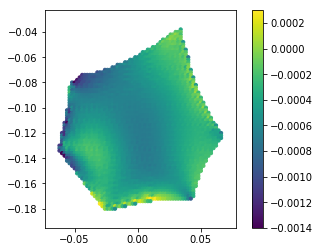

In [156]:
plt.scatter(x,-y,c=ss[:,1,1]-ss[:,0,0],s=10
            ,vmin=-0.0014,vmax=0.0003
#             ,vmin=-0.0041,vmax=-0.0027
#             ,vmin=-0.0051,vmax=-0.0033
#             ,vmin=0.01,vmax=0.013
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

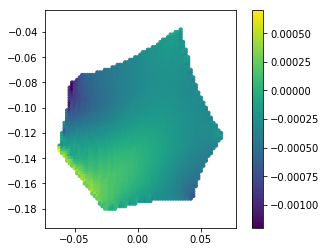

In [149]:
plt.scatter(x,-y,c=ss[:,1,2],s=10
#             ,vmin=-0.0004,vmax=0.0006
            ,vmin=-0.0012,vmax=0.0007
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

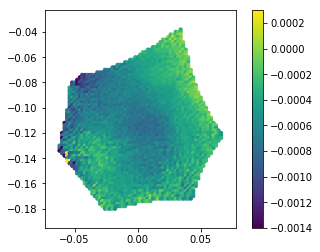

In [157]:
plt.scatter(x,-y,c=S15[:,1,1]-S15[:,0,0],s=10
            ,vmin=-0.0014,vmax=0.0003
#             ,vmin=-0.0041,vmax=-0.0027
#             ,vmin=-0.0051,vmax=-0.0033
#             ,vmin=0.01,vmax=0.013
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

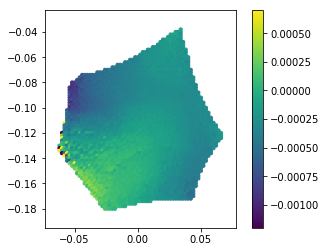

In [146]:
plt.scatter(x,-y,c=S15[:,1,2],s=10
#             ,vmin=-0.0004,vmax=0.0006
            ,vmin=-0.0012,vmax=0.0007
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

In [159]:
np.save('/home/yufengs/SimData/g40_fac20/allMaxS_refined.npy',S15)

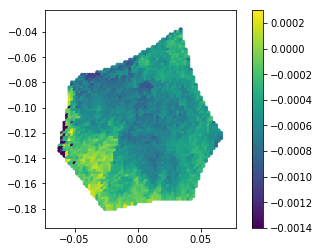

In [158]:
Sold=np.load('/home/yufengs/SimData/g40_fac20/allMaxS.npy')
plt.scatter(x,-y,c=Sold[:,1,1]-Sold[:,0,0],s=10
            ,vmin=-0.0014,vmax=0.0003
#             ,vmin=-0.0041,vmax=-0.0027
#             ,vmin=-0.0051,vmax=-0.0033
#             ,vmin=0.01,vmax=0.013
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

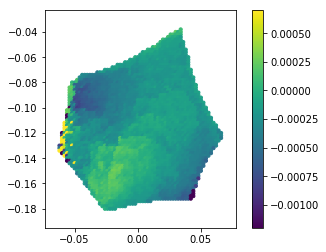

In [145]:
Sold=np.load('/home/yufengs/SimData/g40_fac20/allMaxS.npy')
plt.scatter(x,-y,c=Sold[:,1,2],s=10
#             ,vmin=-0.0004,vmax=0.0006
            ,vmin=-0.0012,vmax=0.0007
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

In [100]:
falseMapsH=falseMapsD.get()

falseMapsH=falseMapsH.reshape((160,300,-1))

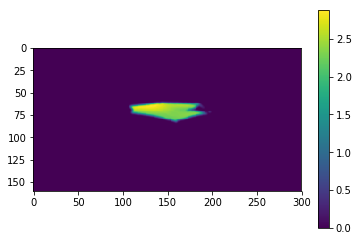

In [151]:
plt.imshow(realMaps[:,:,3*45+17])
plt.colorbar()
plt.show()

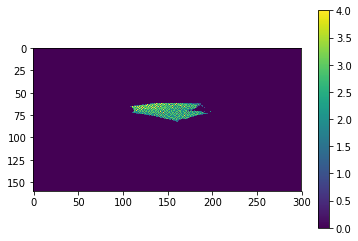

In [152]:
plt.imshow(trueMaps[:,:,3*45+17])
plt.colorbar()
plt.show()

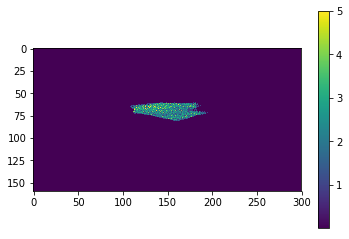

In [153]:
plt.imshow(falseMapsH[:,:,3*45+17])
plt.colorbar()
plt.show()

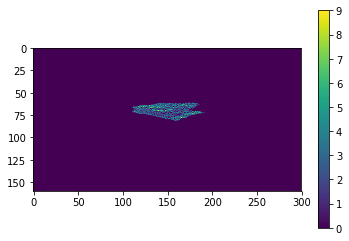

In [154]:
plt.imshow(falseMaps[:,:,3*45+17])
plt.colorbar()
plt.show()